# Setup

In [1]:
import pandas as pd, numpy as np
from pathlib import Path
import fsspec

S3_STATIONS_TXT   = "s3://noaa-ghcn-pds/ghcnd-stations.txt"
S3_INVENTORY_TXT  = "s3://noaa-ghcn-pds/ghcnd-inventory.txt"
S3_BY_STATION     = "s3://noaa-ghcn-pds/csv/by_station/{id}.csv"
STOR = {"anon": True}


OUTDIR = Path('../data'); OUTDIR.mkdir(parents=True, exist_ok=True)
OUT_PARQUET = OUTDIR / 'ghcn_DE_daily.parquet'
OUT_CSV = OUTDIR / 'ghcn_DE_daily.csv'
print('Output:', OUT_PARQUET.resolve())

Output: /home/alissah3/test/data/ghcn_DE_daily.parquet


In [3]:
def download_station(url: 's3://noaa-ghcn-pds/csv/by_station/USC00087205.csv') -> pd.DataFrame:
    df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])
    df['DATA_VALUE'] = df['DATA_VALUE'].replace(-9999, np.nan)
    wide = (df.pivot_table(index=['ID','DATE'], columns='ELEMENT', values='DATA_VALUE', aggfunc='first').reset_index())
    for c in ('TMAX','TMIN','TAVG'):
        if c in wide: wide[c] = wide[c]/10.0
    if 'PRCP' in wide: wide['PRCP'] = wide['PRCP']/10.0
    return wide.sort_values(['ID','DATE']).reset_index(drop=True)


station_id = 'USC00087205'

url = 's3://noaa-ghcn-pds/csv/by_station/USC00087205.csv'

frames = []
w = download_station(url)
frames.append(w)
daily = pd.concat(frames, ignore_index=True)
daily.head()

/tmp/ipykernel_27523/235088600.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])


ELEMENT,ID,DATE,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT06,WT08,WT11,WT14,WT16
0,USC00087205,1892-09-01,NaN,NaN,NaN,NaN,NaN,32.2,20.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00087205,1892-09-02,NaN,NaN,NaN,NaN,NaN,31.7,20.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00087205,1892-09-03,NaN,NaN,NaN,NaN,NaN,31.7,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00087205,1892-09-04,NaN,NaN,NaN,NaN,NaN,32.2,21.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00087205,1892-09-05,NaN,NaN,NaN,NaN,NaN,33.3,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1) 

In [4]:
daily['DATE'] = pd.to_datetime(daily['DATE'])

In [5]:
daily_91_20 = daily[daily['DATE'] >= '1991-01-01']

daily_91_20 = daily_91_20[daily_91_20['DATE'] <= '2020-12-31']

In [6]:
daily_91_20

ELEMENT,ID,DATE,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT06,WT08,WT11,WT14,WT16
33520,USC00087205,1991-01-01,NaN,NaN,0.0,0.0,0.0,28.3,16.7,217.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33521,USC00087205,1991-01-02,NaN,NaN,0.0,0.0,0.0,26.7,18.3,233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33522,USC00087205,1991-01-03,NaN,NaN,0.0,0.0,0.0,26.1,17.8,233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33523,USC00087205,1991-01-04,NaN,NaN,0.0,0.0,0.0,25.0,17.8,222.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33524,USC00087205,1991-01-05,NaN,NaN,0.0,0.0,0.0,28.3,17.2,239.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44356,USC00087205,2020-12-27,NaN,NaN,0.0,NaN,NaN,20.6,1.1,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44357,USC00087205,2020-12-28,NaN,NaN,0.0,NaN,NaN,23.3,8.9,222.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44358,USC00087205,2020-12-29,NaN,NaN,0.0,NaN,NaN,24.4,11.7,233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44359,USC00087205,2020-12-30,NaN,NaN,0.0,NaN,NaN,26.1,12.8,244.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
months = [9, 10, 11, 12, 1]

daily_months = daily_91_20[daily_91_20['DATE'].dt.month.isin(months)]

In [8]:
daily_months

ELEMENT,ID,DATE,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT06,WT08,WT11,WT14,WT16
33520,USC00087205,1991-01-01,NaN,NaN,0.0,0.0,0.0,28.3,16.7,217.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33521,USC00087205,1991-01-02,NaN,NaN,0.0,0.0,0.0,26.7,18.3,233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33522,USC00087205,1991-01-03,NaN,NaN,0.0,0.0,0.0,26.1,17.8,233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33523,USC00087205,1991-01-04,NaN,NaN,0.0,0.0,0.0,25.0,17.8,222.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33524,USC00087205,1991-01-05,NaN,NaN,0.0,0.0,0.0,28.3,17.2,239.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44356,USC00087205,2020-12-27,NaN,NaN,0.0,NaN,NaN,20.6,1.1,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44357,USC00087205,2020-12-28,NaN,NaN,0.0,NaN,NaN,23.3,8.9,222.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44358,USC00087205,2020-12-29,NaN,NaN,0.0,NaN,NaN,24.4,11.7,233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44359,USC00087205,2020-12-30,NaN,NaN,0.0,NaN,NaN,26.1,12.8,244.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
daily_b32 = daily_months[daily_months['TMAX'] <= 32]

daily_b28 = daily_months[daily_months['TMAX'] <= 28]

In [10]:
b_32 = len(daily_b32)/len(daily_months)

b_28 = len(daily_b28)/len(daily_months)

print('Fraction of days below 32:', b_32)
print('Fraction of days below 28:', b_28)

Fraction of days below 32: 0.8326414682106184
Fraction of days below 28: 0.5527638190954773


# 2) 

In [11]:
url_enso = 'https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices'


enso = pd.read_csv(url_enso,sep=r'\s+',skiprows=0,skipfooter=0, engine='python')
enso

,YR,MON,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49
...,...,...,...,...,...,...,...,...,...,...
522,2025,7,22.29,0.46,25.92,0.04,28.84,0.05,27.24,-0.06
523,2025,8,21.09,0.23,24.97,-0.24,28.63,-0.06,26.58,-0.33
524,2025,9,20.40,-0.18,24.60,-0.41,28.41,-0.27,26.32,-0.44
525,2025,10,20.83,-0.04,24.74,-0.35,28.36,-0.33,26.29,-0.48


In [12]:
daily_b28['MON'] = daily_b28['DATE'].dt.month

/tmp/ipykernel_27523/2049736533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_b28['MON'] = daily_b28['DATE'].dt.month


In [13]:
merged = pd.merge(daily_b28, enso, on='MON')

In [14]:
merged

,ID,DATE,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,...,MON,YR,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3
0,USC00087205,1991-01-02,NaN,NaN,0.0,0.0,0.0,26.7,18.3,233.0,...,1,1982,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08
1,USC00087205,1991-01-02,NaN,NaN,0.0,0.0,0.0,26.7,18.3,233.0,...,1,1983,26.82,2.30,28.37,2.69,28.63,0.41,28.70,2.13
2,USC00087205,1991-01-02,NaN,NaN,0.0,0.0,0.0,26.7,18.3,233.0,...,1,1984,24.35,-0.16,24.80,-0.87,27.41,-0.81,25.60,-0.96
3,USC00087205,1991-01-02,NaN,NaN,0.0,0.0,0.0,26.7,18.3,233.0,...,1,1985,23.59,-0.93,24.28,-1.39,27.39,-0.83,25.26,-1.30
4,USC00087205,1991-01-02,NaN,NaN,0.0,0.0,0.0,26.7,18.3,233.0,...,1,1986,24.50,-0.02,24.80,-0.87,27.70,-0.52,25.84,-0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110515,USC00087205,2020-12-30,NaN,NaN,0.0,NaN,NaN,26.1,12.8,244.0,...,12,2020,21.98,-0.86,24.56,-0.70,27.60,-0.85,25.66,-0.99
110516,USC00087205,2020-12-30,NaN,NaN,0.0,NaN,NaN,26.1,12.8,244.0,...,12,2021,21.31,-1.53,24.06,-1.21,27.68,-0.76,25.60,-1.05
110517,USC00087205,2020-12-30,NaN,NaN,0.0,NaN,NaN,26.1,12.8,244.0,...,12,2022,22.54,-0.30,24.48,-0.78,27.71,-0.73,25.81,-0.84
110518,USC00087205,2020-12-30,NaN,NaN,0.0,NaN,NaN,26.1,12.8,244.0,...,12,2023,24.25,1.41,27.33,2.06,29.84,1.39,28.64,1.99


In [15]:
import seaborn as sns

cols = ['TMAX', 'TMIN', 'NINO1+2', 'NINO3', 'NINO4', 'NINO3.4']

df = merged[cols]
corr = df.corr()

corr

,TMAX,TMIN,NINO1+2,NINO3,NINO4,NINO3.4
TMAX,1.000000,0.701072,-0.246691,-0.055512,0.072299,0.026481
TMIN,0.701072,1.000000,-0.258230,-0.058386,0.073537,0.026623
NINO1+2,-0.246691,-0.258230,1.000000,0.678526,0.161552,0.405660
NINO3,-0.055512,-0.058386,0.678526,1.000000,0.729669,0.927625
NINO4,0.072299,0.073537,0.161552,0.729669,1.000000,0.902089
NINO3.4,0.026481,0.026623,0.405660,0.927625,0.902089,1.000000


#### Based on the correlation matrix provided above, both TMIN and TMAX appear to have the highest correlation with the NINO1+2 region


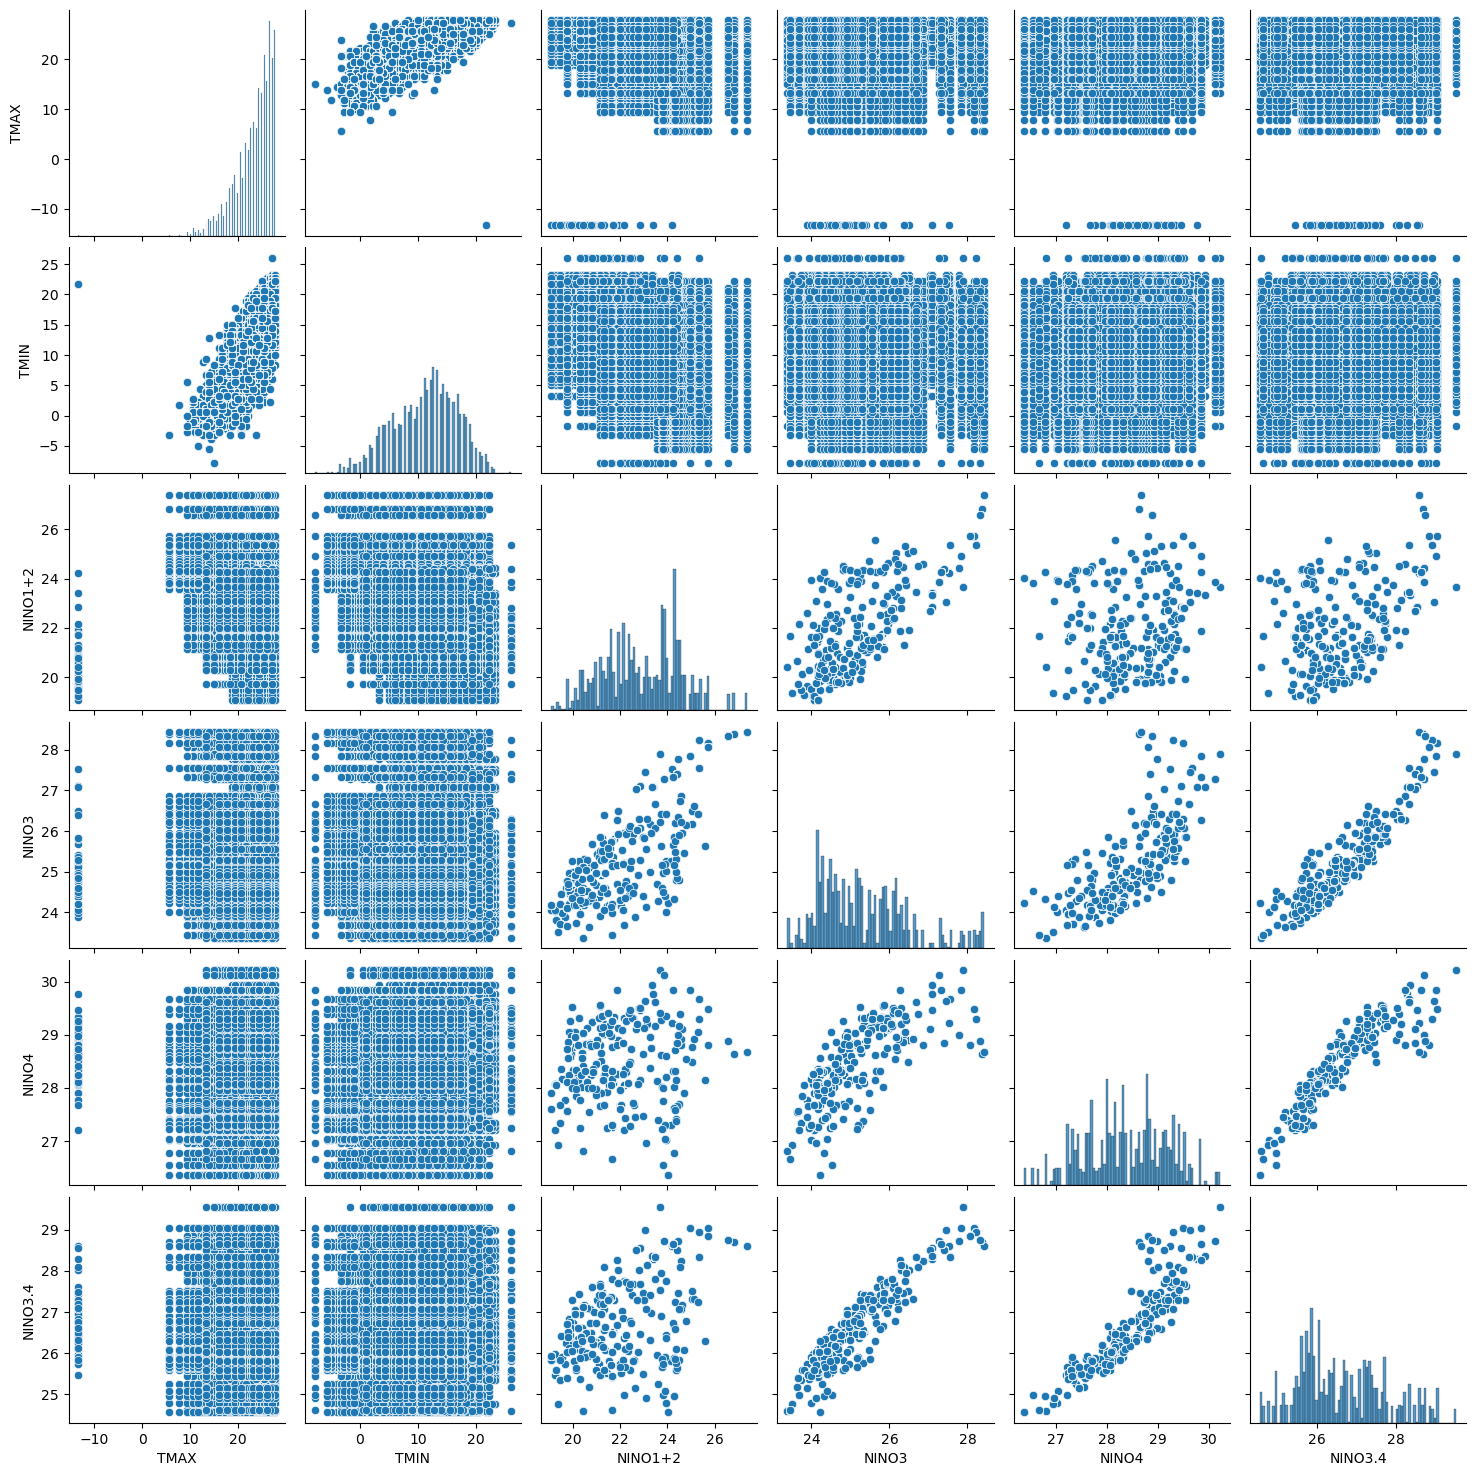

In [16]:
sns.pairplot(df)